# Deep Learning with PyTorch : Build an AutoEncoder

An autoencoder is a type of neural network that learns to copy its input to its output. In autoencoder, encoder encodes the image into compressed representation, and the decoder decodes the representation.

![](denoising_autoencoder.png)

Applications of AutoEncoder:

- Segmentation
- Denoising Image
- Super Resolution Image
- Image Compression
- and many more .....

In this Project, you will see the simplest implemention of autoencoder for image denoising task.

In [1]:
import torch 
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 

# Exploring Dataset 

In [2]:
data = pd.read_csv('mnist_dataset.csv')
data.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


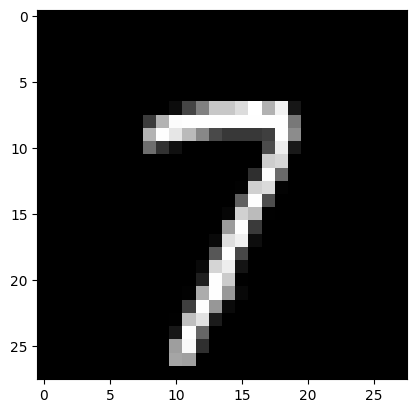

In [3]:
image = data.iloc[18]  # selecting image at index 18
image = np.array(image).astype('float32')
# a column in the data represents 784 pixels
# reshape it to 28x28 pixels
# (784,) -> (28, 28)

image = np.reshape(image, (28, 28))
image = image / 255.0 # scaling: pixel between 0 and 1

plt.imshow(image, cmap='gray')

In [4]:
noisy_image = image + 0.2 * np.random.randn(*image.shape)
noisy_image = np.clip(noisy_image, 0, 1)

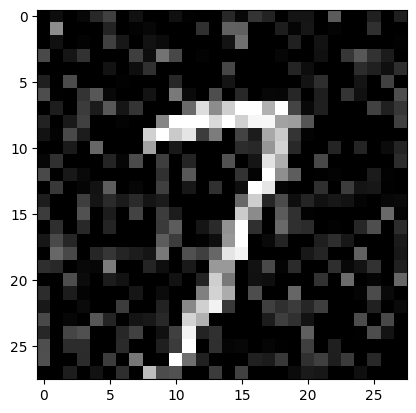

In [5]:
plt.imshow(noisy_image, cmap='gray')

# Data Preparation 

In [6]:
from torch.utils.data import Dataset
from helper import show_image, ToTensorForAE # AE: auto-encoder

<img src="dataset.png" alt="drawing" width="400"/>

In [7]:
class MNIST_AE_Dataset(Dataset):
    def __init__(self, csv_file, noise_factor=0.2, transform=None):
        self.data = pd.read_csv(csv_file)
        self.noise_factor = noise_factor
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = self.data.iloc[idx]
        img = np.array(img)
        img = np.reshape(img, (28, 28, 1)) / 255  # channel: 1
        
        noisy_img = img + self.noise_factor * np.random.randn(*img.shape)
        noisy_img = np.clip(noisy_img, 0, 1)
        
        sample = (noisy_img, img)
        
        if self.transform is not None:
            sample = self.transform(sample)
        
        return sample
        
    

### **Here to ToTensorForAE() is a custom transform which will convert numpy,PIL image to torch tensor and also it will convert image with (height,width,channel) to (channel,height,width) as per the pytorch model input convention.**

For eg, numpy array image with shape (28,28,1) will be first converted to image torch tensor with shape(28,28,1)
and then the channel is shifted to 0th axis so image tensor will be with shape (1,28,28)

In [8]:
trainset = MNIST_AE_Dataset('mnist_dataset.csv', noise_factor=0.2, transform=ToTensorForAE())

In [9]:
print(f"Size of training set: {len(trainset)}")

Size of training set: 42000


In [10]:
noisy_img, orig_img = trainset[32]

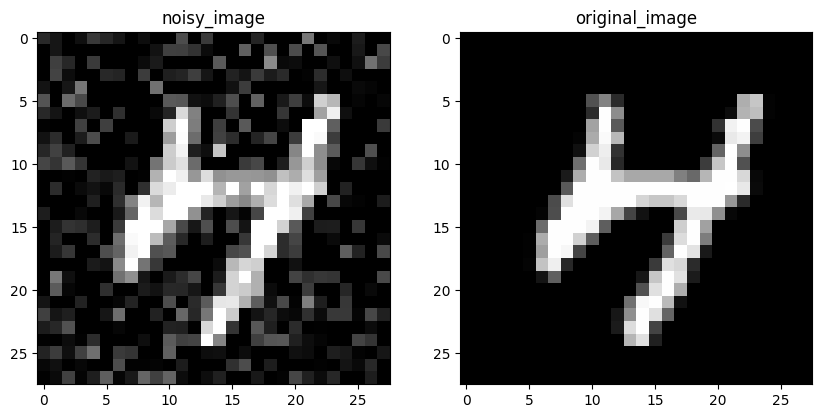

In [11]:
show_image(noisy_img, orig_img)

# Load dataset into batches

In [12]:
from torch.utils.data import DataLoader

In [13]:
trainloader = DataLoader(trainset, batch_size=16, shuffle=True)

In [16]:
dataiter = iter(trainloader)
noisy_img, orig_img = next(dataiter)

print(f"Shape of loading one batch {noisy_img.shape}")


print(f"Total number of batches {len(trainloader)}")
print(f"Total number of examples {len(trainloader.dataset)}")

Shape of loading one batch torch.Size([16, 1, 28, 28])
Total number of batches 2625
Total number of examples 42000


# Create AutoEncoder Model

In [20]:
from torch import nn
from torchsummary import summary

In [21]:
def Encoder():
    encoder = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3,3), padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2)),
    )
    
    return encoder

In [22]:
def Decoder():
    
    decoder = nn.Sequential(
        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(2,2), stride=2),
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(2,2), stride=2),
        nn.Sigmoid()
    )
    
    return decoder

In [23]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, input_images):
        encoder_output = self.encoder(input_images)
        decoder_output = self.decoder(encoder_output)
        
        return decoder_output

model = AutoEncoder()
model

        

AutoEncoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(2, 2), stride=(2, 2))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(2, 2), stride=(2, 2))
    (3): Sigmoid()
  )
)

In [24]:
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 14, 14]           4,640
              ReLU-5           [-1, 32, 14, 14]               0
         MaxPool2d-6             [-1, 32, 7, 7]               0
   ConvTranspose2d-7           [-1, 16, 14, 14]           2,064
              ReLU-8           [-1, 16, 14, 14]               0
   ConvTranspose2d-9            [-1, 1, 28, 28]              65
          Sigmoid-10            [-1, 1, 28, 28]               0
Total params: 6,929
Trainable params: 6,929
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.38
Params size (MB): 0.03
Estimated Total

# Train AutoEncoder Model 

In [25]:
from tqdm import tqdm

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
epochs = 10


In [26]:
for i in range(epochs):
    train_loss = 0.0
    
    model.train()
    for batch in tqdm(trainloader):
        noisy_img, orig_img = batch
        
        denoised_img = model(noisy_img)
        loss = criterion(denoised_img, orig_img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    avg_train_loss = train_loss / len(trainloader)
    
    print(f"Epoch {i+1} Training Loss: {avg_train_loss}")

100%|██████████| 2625/2625 [00:16<00:00, 156.82it/s]


Epoch 1 Training Loss: 0.013946879813358896


100%|██████████| 2625/2625 [00:15<00:00, 170.85it/s]


Epoch 2 Training Loss: 0.005549534472415135


100%|██████████| 2625/2625 [00:13<00:00, 196.27it/s]


Epoch 3 Training Loss: 0.005152908387904366


100%|██████████| 2625/2625 [00:13<00:00, 196.12it/s]


Epoch 4 Training Loss: 0.004966191433192719


100%|██████████| 2625/2625 [00:13<00:00, 195.27it/s]


Epoch 5 Training Loss: 0.004854142746666358


100%|██████████| 2625/2625 [00:16<00:00, 162.13it/s]


Epoch 6 Training Loss: 0.004779647605759757


100%|██████████| 2625/2625 [00:14<00:00, 183.98it/s]


Epoch 7 Training Loss: 0.004717810065352491


100%|██████████| 2625/2625 [00:13<00:00, 197.68it/s]


Epoch 8 Training Loss: 0.004668189065176106


100%|██████████| 2625/2625 [00:13<00:00, 197.59it/s]


Epoch 9 Training Loss: 0.004620762849315291


100%|██████████| 2625/2625 [00:13<00:00, 197.45it/s]

Epoch 10 Training Loss: 0.004580686704566081


# Plot Results

torch.Size([1, 28, 28])


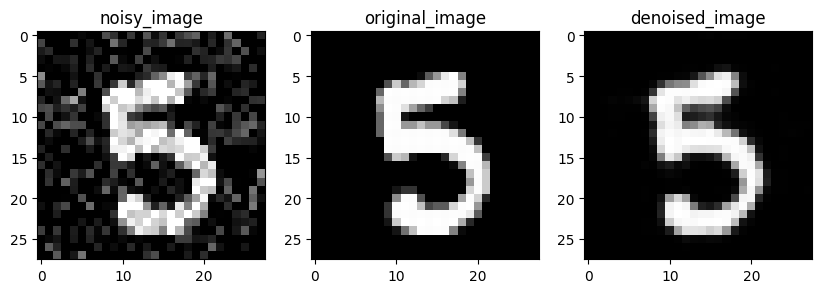

In [31]:
model.eval()

with torch.no_grad():
    
    dataiter = iter(trainloader)
    sample = next(dataiter)
    
    noisy_img, orig_img = sample
    
    index = 15
    
    denoised_img = model(noisy_img[index].unsqueeze(0))  # unsqueeze => (c,h,w) -> (bs,c,h,w)
    print(denoised_img.squeeze(0).shape)
    
    show_image(noisy_img[index], orig_img[index], denoised_img.squeeze(0))
    